In [ ]:
#Reference:
#https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html

In [4]:
import rdkit
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [9]:
data=pd.read_csv('clean_data.csv')
data.head()

,Unnamed: 0,molecule_chembl_id,canonical_smiles,standard_type,standard_value,standard_units,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB,bioactivity_class
0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,active
1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,inactive
2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,active
3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,inactive
4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,416.026,5.1731,107.3846,2.0,3.0,26.0,2.0,43.70,3.0,inactive


In [11]:
data.rename(columns={'canonical_smiles': 'smiles'}, inplace=True)
data.head()

,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,HeavyAtomMolWt,LogP,MolMR,NumHDonors,NumHAcceptors,NumAtoms,AR,TPSA,RB,bioactivity_class
0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,active
1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,273.634,2.8477,81.1270,0.0,3.0,20.0,1.0,29.54,2.0,inactive
2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,active
3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,282.190,1.8677,80.3415,0.0,5.0,22.0,1.0,55.84,3.0,inactive
4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,416.026,5.1731,107.3846,2.0,3.0,26.0,2.0,43.70,3.0,inactive


In [12]:
matches = []
clean = []
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
data = data.loc[clean]  # keep molecules without PAINS

100%|██████████████████████████████████████| 6029/6029 [00:07<00:00, 799.06it/s]


In [13]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(data)}")

Number of compounds with PAINS: 125
Number of compounds without PAINS: 5904


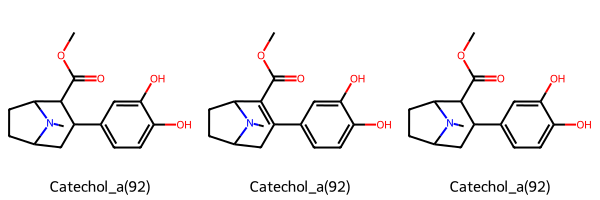

In [14]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

In [16]:
data.to_csv('pains_removed.csv')